In [35]:
import pickle
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from math import log
from collections import Counter
import ast
import nltk
from nltk.util import ngrams

In [36]:
tweets = pd.read_csv("data/tokenized_tweets.csv")
tweets['Date'] = pd.to_datetime(tweets['Date'])
vectorizer_fp = 'classifiers/tfidfvectorizersarik.pkl'
classifier_fp = 'classifiers/ordinallogistic.pkl'

with open(classifier_fp, 'rb') as f:
    classifier = pickle.load(f)

with open(vectorizer_fp, 'rb') as f:
    vectorizer = pickle.load(f)

In [37]:
def classify_tweets(classifier, vectorizer, tweets, drop_duplicates=False):
    if drop_duplicates:
        tweets = tweets.sort_values('Date')
        tweets = tweets.drop_duplicates(subset='Text', keep='first')
    
    X_tokens = vectorizer.transform(tweets['Tokens'])
    predictions = classifier.predict(X_tokens)
    tweets['Predictions'] = predictions
    return tweets

In [38]:
tweets = classify_tweets(classifier, vectorizer, tweets)
tweets['Tokens'] = tweets['Tokens'].apply(ast.literal_eval)
tweets['Hashtags'] = tweets['Hashtags'].apply(ast.literal_eval)
tweets['Handles'] = tweets['Handles'].apply(ast.literal_eval)

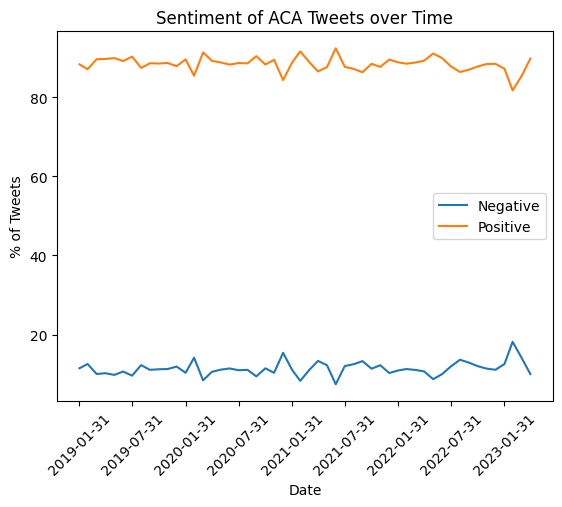

In [39]:
max_prediction = tweets['Predictions'].max()
min_prediction = tweets['Predictions'].min()

grouped_data = tweets.groupby(pd.Grouper(key='Date', freq='M')).agg(
    {'Predictions': ['min', 'max', 'size', lambda x: (
    x == min_prediction).sum(), lambda x: (x == max_prediction).sum()]})
grouped_data.columns = ['Min Prediction', 'Max Prediction', 'Total', 'Min Count', 'Max Count']

grouped_data['Min Frequency'] = grouped_data['Min Count'] / grouped_data['Total'] * 100
grouped_data['Max Frequency'] = grouped_data['Max Count'] / grouped_data['Total'] * 100

plt.plot(grouped_data.index, grouped_data['Min Frequency'], label='Negative')
plt.plot(grouped_data.index, grouped_data['Max Frequency'], label='Positive')

plt.xlabel('Date')
plt.ylabel('% of Tweets')
plt.title('Sentiment of ACA Tweets over Time')
plt.legend()

plt.xticks(rotation=45)
plt.gca().set_xticks(grouped_data.index[::6])

plt.show()

In [40]:
def analyze_sentiment_ngrams(tweets, max_prediction, min_prediction, n, text_type):
    max_token_counts = {}
    min_token_counts = {}
    all_tokens = set()

    max_tweets = tweets[tweets['Predictions'] == max_prediction]
    min_tweets = tweets[tweets['Predictions'] == min_prediction]

    total_max_tweets = len(max_tweets)
    total_min_tweets = len(min_tweets)

    for _, row in max_tweets.iterrows():
        tokens = row[text_type]
        token_ngrams = list(ngrams(tokens, n))
        for token in token_ngrams:
            max_token_counts[token] = max_token_counts.get(token, 0) + 1
            all_tokens.add(token)

    for _, row in min_tweets.iterrows():
        tokens = row[text_type]
        token_ngrams = list(ngrams(tokens, n))
        for token in token_ngrams:
            min_token_counts[token] = min_token_counts.get(token, 0) + 1
            all_tokens.add(token)

    frequency_scores = {}
    for token in all_tokens:
        min_frequency = min_token_counts.get(token, 0) / total_min_tweets
        max_frequency = max_token_counts.get(token, 0) / total_max_tweets
        frequency_score = max_frequency - min_frequency
        frequency_scores[token] = frequency_score

    sorted_scores = sorted(frequency_scores.items(), key=lambda x: x[1], reverse=True)

    print(f"Top {n}-grams associated with positive sentiment:")
    for token, score in sorted_scores[:10]:
        if score > 0:
            print(f"{n}-gram: {token}\tFrequency Score: {score}")

    print(f"Top {n}-grams associated with negative sentiment:")
    for token, score in sorted_scores[-10:]:
        if score < 0:
            print(f"{n}-gram: {token}\tFrequency Score: {score}")


In [43]:
analyze_sentiment_ngrams(tweets, max_prediction, min_prediction, 1, 'Tokens')

Top 1-grams associated with positive sentiment:
1-gram: ('court',)	Frequency Score: 0.04616436935091966
1-gram: ('supreme',)	Frequency Score: 0.03460060553480916
1-gram: ('trump',)	Frequency Score: 0.031914535484133755
1-gram: ('via',)	Frequency Score: 0.0267310566783546
1-gram: ('new',)	Frequency Score: 0.025702408762731575
1-gram: ('de',)	Frequency Score: 0.02486085753964425
1-gram: ('gop',)	Frequency Score: 0.024435911154876488
1-gram: ('republican',)	Frequency Score: 0.023132847082338072
1-gram: ('affordable',)	Frequency Score: 0.0215367728020892
1-gram: ('biden',)	Frequency Score: 0.020490682015128145
Top 1-grams associated with negative sentiment:
1-gram: ('never',)	Frequency Score: -0.08392973338335417
1-gram: ('like',)	Frequency Score: -0.08948280185740223
1-gram: ('money',)	Frequency Score: -0.09398352013131982
1-gram: ('didnt',)	Frequency Score: -0.10023116224050979
1-gram: ('said',)	Frequency Score: -0.11067719186640741
1-gram: ('would',)	Frequency Score: -0.1391033642993399